Bridge chart




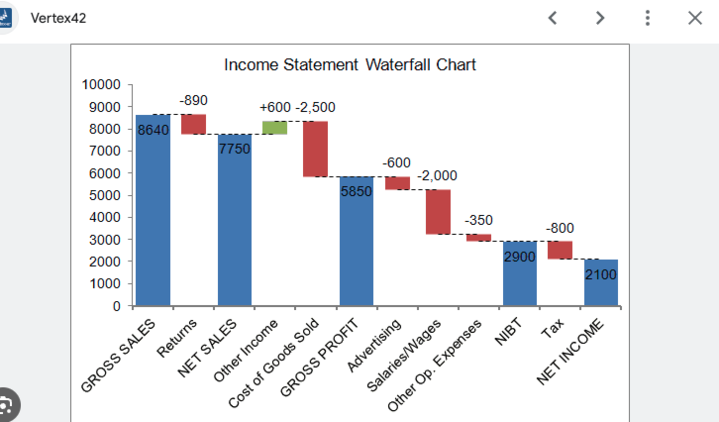


when we take fees that reduces nav/share because it increase the quantity of shares


#### For the previous month

Each of these modifies either Nav or shares, at each point

we need the nav and total shares are each of these points



Autopool profit, per autopool


- Autopool Total ETH value earned (current nav) - (expected nav if nav per share did not change)
- Total Eth taken in fees sum (ETH fees in each fee Event)
- Total ETH value lost in rebalance costs  (this increases NAV)

- have both the apr plots and the bridge plot of the



Tokemak profit
- Across all autopools, what was the fees for the month,
- In the prior month, how much did we pay for the solver
- in the prior month, how much did we pay for the chainlink keepers
- in the prior month, how much did we pay for the reward token liquidation

<!-- 
This is another one - liquidation price of our incentives compared to the then existing price from our pricer -->

we care about the persent change in nav /share 

the bars (for both 1 & 2) are 1. net return annualized 2. gross return (before fees) 3. gross return (before fees & assuming no rebalance txn loss i.e. swap/slippage loss)

In [1]:
import pandas as pd
import streamlit as st
from datetime import timedelta
from multicall import Call
import plotly.express as px
import json

import numpy as np
import plotly.io as pio

pio.templates.default = None

from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    get_state_by_one_block,
    identity_with_bool_success,
    safe_normalize_with_bool_success,
    add_timestamp_to_df_with_block_column,
    build_blocks_to_use,
    eth_client,
)

from mainnet_launch.data_fetching.get_events import fetch_events

from mainnet_launch.constants import AUTO_ETH, AUTO_LRT, BAL_ETH, eth_client, AutopoolConstants
from mainnet_launch.abis.abis import AUTOPOOL_VAULT_ABI, AUTOPOOL_ETH_STRATEGY_ABI

import pandas as pd
import streamlit as st
from multicall import Call
from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    add_timestamp_to_df_with_block_column,
    build_blocks_to_use,
    safe_normalize_with_bool_success,
)
import plotly.express as px


def handle_getAssetBreakdown(success, AssetBreakdown):
    if success:
        totalIdle, totalDebt, totalDebtMin, totalDebtMin = AssetBreakdown
        return int(totalIdle + totalDebt) / 1e18
    return None


def getAssetBreakdown_call(name: str, autopool_vault_address: str) -> Call:
    return Call(
        autopool_vault_address,
        ["getAssetBreakdown()((uint256,uint256,uint256,uint256))"],
        [(name, handle_getAssetBreakdown)],
    )


def totalSupply_call(name: str, autopool_vault_address: str) -> Call:
    return Call(
        autopool_vault_address,
        ["totalSupply()(uint256)"],
        [(name, safe_normalize_with_bool_success)],
    )


def build_actual_nav_per_share_df(autopool: AutopoolConstants) -> pd.DataFrame:

    calls = [
        getAssetBreakdown_call("actual_nav", autopool.autopool_eth_addr),
        totalSupply_call("actual_shares", autopool.autopool_eth_addr),
    ]
    blocks = build_blocks_to_use()
    df = get_raw_state_by_blocks(calls, blocks)
    df["actual_nav_per_share"] = df["actual_nav"] / df["actual_shares"]
    daily_nav_shares_df = df.resample("1D").last()
    return daily_nav_shares_df


def build_fee_shares_minted_df(autopool: AutopoolConstants):
    autoETH_vault = eth_client.eth.contract(autopool.autopool_eth_addr, abi=AUTOPOOL_VAULT_ABI)
    FeeCollected_df = add_timestamp_to_df_with_block_column(fetch_events(autoETH_vault.events.FeeCollected))
    PeriodicFeeCollected_df = add_timestamp_to_df_with_block_column(
        fetch_events(autoETH_vault.events.PeriodicFeeCollected)
    )
    PeriodicFeeCollected_df["new_shares_from_periodic_fees"] = PeriodicFeeCollected_df["mintedShares"] / 1e18
    FeeCollected_df["new_shares_from_streaming_fees"] = FeeCollected_df["mintedShares"] / 1e18
    fee_df = pd.concat(
        [
            PeriodicFeeCollected_df[["new_shares_from_periodic_fees"]],
            FeeCollected_df[["new_shares_from_streaming_fees"]],
        ]
    )
    daily_fee_share_df = fee_df.resample("1D").sum()  # double check
    return daily_fee_share_df.cumsum(), daily_fee_share_df


daily_fee_share_df, fee_df = build_fee_shares_minted_df(AUTO_ETH)
daily_nav_shares_df = build_actual_nav_per_share_df(AUTO_ETH)
df = daily_nav_shares_df.join(daily_fee_share_df, how="left").fillna(0)

from mainnet_launch.solver_diagnostics.fetch_rebalance_events import (
    fetch_and_clean_rebalance_between_destination_events,
)

rebalance_df = fetch_and_clean_rebalance_between_destination_events(AUTO_ETH)
daily_nav_lost_to_rebalances = (rebalance_df[["swapCost"]].resample("1D").sum()).cumsum()
daily_nav_lost_to_rebalances.columns = ["eth_nav_lost_by_rebalance_between_destinations"]
df = df.join(daily_nav_lost_to_rebalances, how="left").fillna(0)
df.head()

2024-10-24 13:12:57.289 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-10-24 13:12:59.023 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-24 13:12:59.188 
  command:

    streamlit run /home/parker/Documents/Tokemak/v2-rebalance-dashboard/.venv/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-10-24 13:12:59.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-24 13:12:59.189 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-24 13:12:59.189 No runtime found, using MemoryCacheStorageManager
2024-10-24 13:12:59.267 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-24 13:12:59.267 Thread 'MainThread': missing Sc

,actual_nav,actual_shares,actual_nav_per_share,new_shares_from_periodic_fees,new_shares_from_streaming_fees,eth_nav_lost_by_rebalance_between_destinations
timestamp,,,,,,
2024-09-15 00:00:00+00:00,0.176129,0.176129,1.000000,0.00000,0.0,0.000000
2024-09-16 00:00:00+00:00,902.012316,902.012316,1.000000,0.00000,0.0,0.000000
2024-09-17 00:00:00+00:00,1653.384535,1653.392359,0.999995,0.00000,0.0,0.033739
2024-09-18 00:00:00+00:00,2993.877068,2994.157550,0.999906,0.00000,0.0,0.213260
2024-09-19 00:00:00+00:00,3901.645343,3903.814760,0.999444,0.62561,0.0,1.172403


In [2]:
fee_df

,new_shares_from_periodic_fees,new_shares_from_streaming_fees
timestamp,,
2024-09-19 00:00:00+00:00,0.625610,0.000000
2024-09-20 00:00:00+00:00,0.091670,0.000000
2024-09-21 00:00:00+00:00,0.131287,0.418534
2024-09-22 00:00:00+00:00,0.100057,0.257884
2024-09-23 00:00:00+00:00,0.114859,0.285512
2024-09-24 00:00:00+00:00,0.129339,0.332878
2024-09-25 00:00:00+00:00,0.129859,0.000000
2024-09-26 00:00:00+00:00,0.137648,0.118292
2024-09-27 00:00:00+00:00,0.142733,1.308450


In [3]:
px.bar(df["new_shares_from_periodic_fees"])

In [4]:
round(0.07 * (30 / 365) * 0.01, 6)

5.8e-05

In [5]:
px.line(df["eth_nav_lost_by_rebalance_between_destinations"])

In [6]:
px.line

<function plotly.express._chart_types.line(data_frame=None, x=None, y=None, line_group=None, color=None, line_dash=None, symbol=None, hover_name=None, hover_data=None, custom_data=None, text=None, facet_row=None, facet_col=None, facet_col_wrap=0, facet_row_spacing=None, facet_col_spacing=None, error_x=None, error_x_minus=None, error_y=None, error_y_minus=None, animation_frame=None, animation_group=None, category_orders=None, labels=None, orientation=None, color_discrete_sequence=None, color_discrete_map=None, line_dash_sequence=None, line_dash_map=None, symbol_sequence=None, symbol_map=None, markers=False, log_x=False, log_y=False, range_x=None, range_y=None, line_shape=None, render_mode='auto', title=None, template=None, width=None, height=None) -> plotly.graph_objs._figure.Figure>

In [7]:
# losing some nav means we dont autocompound as as much as we would otherwise
# ignoring this for now for simplicity. Should not matter very much
# at a 7% rate of return over 30 days, if we lose 1% of nav in that way
# the lost compounding is .07 * (30/365) * .01  = 0.000058 apy (about half a basis point over a year if there is a 1% nav loss over that month from rebalances, most extreme case)
# too small to worry about.

df["nav_per_share_if_no_fees"] = df["actual_nav"] / (
    df["actual_shares"] - df["new_shares_from_periodic_fees"] - df["new_shares_from_streaming_fees"]
)
df["nav_per_share_if_no_value_lost_from_rebalances"] = (
    df["actual_nav"] + df["eth_nav_lost_by_rebalance_between_destinations"]
) / df["actual_shares"]


px.line(df[["nav_per_share_if_no_value_lost_from_rebalances", "nav_per_share_if_no_fees", "actual_nav_per_share"]])

In [8]:
def add_30_day_annualized_return_col(df: pd.DataFrame, col: str):
    # this is rolling
    df[f"{col}_30_day_annualized_return"] = (df[col].diff(periods=30) / df[col].shift(30)) * (365 / 30) * 100


add_30_day_annualized_return_col(df, "actual_nav_per_share")
add_30_day_annualized_return_col(df, "nav_per_share_if_no_fees")
add_30_day_annualized_return_col(df, "nav_per_share_if_no_value_lost_from_rebalances")

px.line(
    df[
        [
            "nav_per_share_if_no_fees_30_day_annualized_return",
            "actual_nav_per_share_30_day_annualized_return",
            "nav_per_share_if_no_value_lost_from_rebalances_30_day_annualized_return",
        ]
    ]
)

In [9]:
from mainnet_launch.constants import ROOT_PRICE_ORACLE, INCENTIVE_PRICNIG_STATS


def build_reward_token_acheived_and_spot_liqudiation_prices() -> tuple[pd.DataFrame, pd.DataFrame]:
    swapped_df = _build_swapped_df()

    achieved_eth_price_df = pd.pivot(
        swapped_df, index="date", columns="sellTokenAddress", values="achieved_token_price_in_eth"
    )

    incentive_token_prices_df = _fetch_incentive_token_price_df(swapped_df)

    symbol_calls = [
        Call(addr, ["symbol()(string)"], [(addr, identity_with_bool_success)]) for addr in achieved_eth_price_df.columns
    ]

    token_address_to_symbol = get_state_by_one_block(symbol_calls, eth_client.eth.block_number)
    achieved_eth_price_df.columns = [token_address_to_symbol[c] for c in achieved_eth_price_df.columns]
    incentive_token_prices_df.columns = [token_address_to_symbol[c] for c in incentive_token_prices_df.columns]

    incentive_token_prices_df = incentive_token_prices_df[achieved_eth_price_df.columns]

    return achieved_eth_price_df, incentive_token_prices_df, token_address_to_symbol


def _build_swapped_df():
    LiquidationRow_address = "0xBf58810BB1946429830C1f12205331608c470ff5"
    # this is not on etherscan, you have to get it from the v2-core repo foundry contracts when it makes the ABIs
    SWAPPED_EVENT_ABI = json.loads(
        """[{"inputs":[{"internalType":"address","name":"aggregator","type":"address"}],"stateMutability":"nonpayable","type":"constructor"},{"inputs":[{"internalType":"uint256","name":"balanceNeeded","type":"uint256"},{"internalType":"uint256","name":"balanceAvailable","type":"uint256"}],"type":"error","name":"InsufficientBalance"},{"inputs":[],"type":"error","name":"InsufficientBuyAmount"},{"inputs":[{"internalType":"uint256","name":"buyTokenAmountReceived","type":"uint256"},{"internalType":"uint256","name":"buyAmount","type":"uint256"}],"type":"error","name":"InsufficientBuyAmountReceived"},{"inputs":[],"type":"error","name":"InsufficientSellAmount"},{"inputs":[],"type":"error","name":"SwapFailed"},{"inputs":[],"type":"error","name":"TokenAddressZero"},{"inputs":[{"internalType":"address","name":"sellTokenAddress","type":"address","indexed":true},{"internalType":"address","name":"buyTokenAddress","type":"address","indexed":true},{"internalType":"uint256","name":"sellAmount","type":"uint256","indexed":false},{"internalType":"uint256","name":"buyAmount","type":"uint256","indexed":false},{"internalType":"uint256","name":"buyTokenAmountReceived","type":"uint256","indexed":false}],"type":"event","name":"Swapped","anonymous":false},{"inputs":[],"stateMutability":"view","type":"function","name":"AGGREGATOR","outputs":[{"internalType":"address","name":"","type":"address"}]},{"inputs":[{"internalType":"struct SwapParams","name":"swapParams","type":"tuple","components":[{"internalType":"address","name":"sellTokenAddress","type":"address"},{"internalType":"uint256","name":"sellAmount","type":"uint256"},{"internalType":"address","name":"buyTokenAddress","type":"address"},{"internalType":"uint256","name":"buyAmount","type":"uint256"},{"internalType":"bytes","name":"data","type":"bytes"},{"internalType":"bytes","name":"extraData","type":"bytes"},{"internalType":"uint256","name":"deadline","type":"uint256"}]}],"stateMutability":"nonpayable","type":"function","name":"swap","outputs":[{"internalType":"uint256","name":"buyTokenAmountReceived","type":"uint256"}]}]"""
    )
    contract = eth_client.eth.contract(LiquidationRow_address, abi=SWAPPED_EVENT_ABI)
    swapped_df = add_timestamp_to_df_with_block_column(fetch_events(contract.events.Swapped))

    def _get_achieved_price(row):
        if (
            row["sellTokenAddress"] == "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48"
        ):  # usdc #TODO swich to decimals check
            normalized_sell_amount = row["sellAmount"] / 1e6
        else:
            normalized_sell_amount = row["sellAmount"] / 1e18

        normalized_buy_amount = row["buyTokenAmountReceived"] / 1e18

        return normalized_buy_amount / normalized_sell_amount

    swapped_df["achieved_token_price_in_eth"] = swapped_df.apply(lambda row: _get_achieved_price(row), axis=1)
    swapped_df["date"] = swapped_df.index
    return swapped_df


def _fetch_incentive_token_price_df(swapped_df: pd.DataFrame):

    def _min_of_low_and_high_price(success, data):
        if success:
            fast, slow = data
            return min(fast, slow) / 1e18
        return None

    def getIncentiveTokenPrice(name: str, token_address: str) -> Call:
        return Call(
            INCENTIVE_PRICNIG_STATS,
            ["getPrice(address,uint40)((uint256,uint256))", token_address, 2 * 86400],  # 2 days
            [(name, _min_of_low_and_high_price)],
        )

    token_addresses = swapped_df["sellTokenAddress"].unique()
    calls = [getIncentiveTokenPrice(addr, addr) for addr in token_addresses]

    blocks_to_get_incentive_token_prices = swapped_df["block"].unique()
    incentive_token_prices_df = get_raw_state_by_blocks(calls, blocks_to_get_incentive_token_prices)
    return incentive_token_prices_df


achieved_eth_price_df, incentive_token_prices_df, token_address_to_symbol = (
    build_reward_token_acheived_and_spot_liqudiation_prices()
)
achieved_eth_price_df

                                                     sellTokenAddress  \
timestamp                                                               
2024-10-24 06:25:23+00:00  0xba100000625a3754423978a60c9317c58a424e3D   
2024-10-24 06:25:23+00:00  0x6DF0E641FC9847c0c6Fde39bE6253045440c14d3   
2024-10-24 06:25:23+00:00  0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48   
2024-10-24 06:25:23+00:00  0x4e3FBD56CD56c3e72c1403e103b45Db9da5B9D2B   
2024-10-24 06:27:35+00:00  0xD533a949740bb3306d119CC777fa900bA034cd52   

                                                      buyTokenAddress  \
timestamp                                                               
2024-10-24 06:25:23+00:00  0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2   
2024-10-24 06:25:23+00:00  0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2   
2024-10-24 06:25:23+00:00  0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2   
2024-10-24 06:25:23+00:00  0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2   
2024-10-24 06:27:35+00:00  0xC02aaA39b223FE8D0A0e5

,SWISE,CVX,DINERO,USDC,AURA,CRV,BAL
date,,,,,,,
2024-09-19 19:06:47+00:00,NaN,0.000846,NaN,0.000404,0.000162,0.000115,0.000753
2024-09-20 22:04:35+00:00,NaN,0.000841,0.000026,0.000391,0.000156,NaN,0.000772
2024-09-20 22:35:59+00:00,NaN,NaN,0.000026,0.000391,0.000184,0.000116,0.000771
2024-09-20 22:36:11+00:00,NaN,0.000841,NaN,NaN,NaN,NaN,NaN
2024-09-21 21:05:11+00:00,NaN,0.000877,0.000026,0.000389,0.000157,NaN,0.000772
...,...,...,...,...,...,...,...
2024-10-23 06:25:11+00:00,NaN,0.000678,NaN,0.000381,0.000131,0.000098,0.000753
2024-10-23 18:25:23+00:00,NaN,0.000683,0.000016,0.000402,0.000131,NaN,0.000746
2024-10-24 00:24:59+00:00,NaN,NaN,NaN,NaN,NaN,0.000100,NaN


In [22]:
px.scatter(achieved_eth_price_df)

In [23]:
px.scatter(incentive_token_prices_df)

In [18]:
percent_achieved_less_than_pricer_price = 100 * (
    (achieved_eth_price_df - incentive_token_prices_df) / incentive_token_prices_df
)
percent_achieved_less_than_pricer_price

,SWISE,CVX,DINERO,USDC,AURA,CRV,BAL
date,,,,,,,
2024-09-19 19:06:47+00:00,NaN,-0.743179,NaN,-3.722417,-5.905974,-1.150033,-2.768548
2024-09-20 22:04:35+00:00,NaN,1.192302,-3.532521,-2.440685,-5.550744,NaN,-0.502789
2024-09-20 22:35:59+00:00,NaN,NaN,-3.522752,-2.497506,11.548117,3.023922,-0.580624
2024-09-20 22:36:11+00:00,NaN,1.180077,NaN,NaN,NaN,NaN,NaN
2024-09-21 21:05:11+00:00,NaN,2.285802,-0.290205,-1.384983,-1.042294,NaN,-0.532488
...,...,...,...,...,...,...,...
2024-10-23 06:25:11+00:00,NaN,-2.101806,NaN,0.525853,-1.488880,-1.064025,-3.736560
2024-10-23 18:25:23+00:00,NaN,-0.729313,0.255582,4.620589,-1.803123,NaN,-4.424415
2024-10-24 00:24:59+00:00,NaN,NaN,NaN,NaN,NaN,0.960949,NaN


In [34]:
fig = px.histogram(percent_achieved_less_than_pricer_price, histnorm="percent")
fig.update_xaxes(title_text="Percent diff between achieved vs min(fast, slow price)")

In [10]:
incentive_token_prices_df.tail(1).values

array([[6.13458042e-06, 6.84459542e-04, 1.58051615e-05, 3.85242087e-04,
        1.33523130e-04, 9.95654434e-05, 7.77500753e-04]])

In [11]:
100892476312557 / 1e18

0.000100892476312557

In [12]:
60 * 60 * 24

86400

In [13]:
token_address_to_symbol

{'0x48C3399719B582dD63eB5AADf12A40B4C3f52FA2': 'SWISE',
 '0x4e3FBD56CD56c3e72c1403e103b45Db9da5B9D2B': 'CVX',
 '0x6DF0E641FC9847c0c6Fde39bE6253045440c14d3': 'DINERO',
 '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48': 'USDC',
 '0xC0c293ce456fF0ED870ADd98a0828Dd4d2903DBF': 'AURA',
 '0xD533a949740bb3306d119CC777fa900bA034cd52': 'CRV',
 '0xba100000625a3754423978a60c9317c58a424e3D': 'BAL'}

In [14]:
ROOT_PRICE_ORACLE

'0x61F8BE7FD721e80C0249829eaE6f0DAf21bc2CaC'

In [15]:
achieved_eth_price_df

,SWISE,CVX,DINERO,USDC,AURA,CRV,BAL
date,,,,,,,
2024-09-19 19:06:47+00:00,NaN,0.000846,NaN,0.000404,0.000162,0.000115,0.000753
2024-09-20 22:04:35+00:00,NaN,0.000841,0.000026,0.000391,0.000156,NaN,0.000772
2024-09-20 22:35:59+00:00,NaN,NaN,0.000026,0.000391,0.000184,0.000116,0.000771
2024-09-20 22:36:11+00:00,NaN,0.000841,NaN,NaN,NaN,NaN,NaN
2024-09-21 21:05:11+00:00,NaN,0.000877,0.000026,0.000389,0.000157,NaN,0.000772
...,...,...,...,...,...,...,...
2024-10-23 06:25:11+00:00,NaN,0.000678,NaN,0.000381,0.000131,0.000098,0.000753
2024-10-23 18:25:23+00:00,NaN,0.000683,0.000016,0.000402,0.000131,NaN,0.000746
2024-10-24 00:24:59+00:00,NaN,NaN,NaN,NaN,NaN,0.000100,NaN


,SWISE,CVX,DINERO,USDC,AURA,CRV,BAL
date,,,,,,,
2024-09-19 19:06:47+00:00,NaN,-0.743179,NaN,-3.722417,-5.905974,-1.150033,-2.768548
2024-09-20 22:04:35+00:00,NaN,1.192302,-3.532521,-2.440685,-5.550744,NaN,-0.502789
2024-09-20 22:35:59+00:00,NaN,NaN,-3.522752,-2.497506,11.548117,3.023922,-0.580624
2024-09-20 22:36:11+00:00,NaN,1.180077,NaN,NaN,NaN,NaN,NaN
2024-09-21 21:05:11+00:00,NaN,2.285802,-0.290205,-1.384983,-1.042294,NaN,-0.532488
...,...,...,...,...,...,...,...
2024-10-23 06:25:11+00:00,NaN,-2.101806,NaN,0.525853,-1.488880,-1.064025,-3.736560
2024-10-23 18:25:23+00:00,NaN,-0.729313,0.255582,4.620589,-1.803123,NaN,-4.424415
2024-10-24 00:24:59+00:00,NaN,NaN,NaN,NaN,NaN,0.960949,NaN


In [17]:
for col in percent_achieved_less_than_pricer_price.columns:
    fig = px.histogram(
    percent_achieved_less_than_pricer_price[[col]], histnorm="probability density",
        title=f"Achieved vs Pricer Price for {col}", x
)
    fig.show()

SyntaxError: positional argument follows keyword argument (1271701356.py, line 5)

In [ ]:
100_000_000

In [ ]:
# negative values mean the price we got was worse than the price we thought it was worth

In [ ]:
(100 * ((acheived_eth_price_df - incnetive_token_price_df) / incnetive_token_price_df).mean())

In [ ]:
for col in acheived_eth_price_df.columns:
    fig = px.histogram(
        ((acheived_eth_price_df[col] - incnetive_token_price_df[col]) / incnetive_token_price_df[col]),
        title="Distribution of Achieved vs rootPrice Oracle Price" + col,
        histnorm="probability density",
    )
    fig.show()

In [ ]:
acheived_eth_price_df2 = acheived_eth_price_df.copy()
incnetive_token_price_df2 = incnetive_token_price_df.copy()

acheived_eth_price_df2.columns = ["liquidation_price" + c for c in acheived_eth_price_df.columns]
incnetive_token_price_df2.columns = ["pricer_price" + c for c in incnetive_token_price_df.columns]

both_prices_df = pd.concat([acheived_eth_price_df2, incnetive_token_price_df2], axis=1)
both_prices_df

In [ ]:
px.l

In [ ]:
for col in acheived_eth_price_df.columns:
    px.line(acheived_eth_price_df[])

In [ ]:
px.histogram((incnetive_token_price_df - acheived_eth_price_df))

In [ ]:
names

In [ ]:
addresses

In [ ]:
calls = []

ROOT_PRICE_ORACLE

In [ ]:
acheived_eth_price_df.columns

In [ ]:
swapped_df[swapped_df["sellTokenAddress"] == "0xC0c293ce456fF0ED870ADd98a0828Dd4d2903DBF"].iloc[3]["hash"]

In [ ]:
swapped_df.groupby("sellTokenAddress")["sellAmount"].sum()

In [ ]:
swapped_df["token_received_diff"] = (swapped_df["buyAmount"] - swapped_df["buyTokenAmountReceived"]) / 1e18

px.line(swapped_df["token_received_diff"])

In [27]:
# maybe they spend .18ETH in gas?

In [ ]:
from mainnet_launch.abis.abi_signature_from_abi_utils import get_function_and_event_signatures_with_returns

get_function_and_event_signatures_with_returns(abi)

In [ ]:
ab

In [ ]:
# def _fetch_incentive_token_price_df(swapped_df:pd.DataFrame):

#     def getPriceInEth_call(name: str, token_address: str) -> Call:
#         return Call(
#             ROOT_PRICE_ORACLE,
#             ["getPriceInEth(address)(uint256)", token_address],
#             [(name, safe_normalize_with_bool_success)],
#         )

#     token_addresses = swapped_df['sellTokenAddress'].unique()
#     calls = [getPriceInEth_call(addr, addr) for addr in token_addresses]

#     blocks_to_get_incentive_token_prices = swapped_df["block"].unique()
#     incentive_token_prices_df = get_raw_state_by_blocks(calls, blocks_to_get_incentive_token_prices)
#     return incentive_token_prices_df

# def _fetch_incentive_token_price_df(swapped_df:pd.DataFrame):

#     def getPriceInEth_call(name: str, token_address: str) -> Call:
#         return Call(
#             ROOT_PRICE_ORACLE,
#             ["getPriceInEth(address)(uint256)", token_address],
#             [(name, safe_normalize_with_bool_success)],
#         )